# Capstone Project - Predictive Undewriting Decision Model

## Modelling & Conclusion

* import from previous notebook using pickle

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, PrecisionRecallDisplay, ConfusionMatrixDisplay, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, roc_auc_score, recall_score, precision_score
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})
pd.pandas.set_option('display.max_columns', None)
#to display max rows
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000

In [3]:
df = pd.read_pickle("./data/df.pkl")

In [4]:
df.shape

(59381, 118)

In [5]:
df.head()

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,0.2500,1,2,6,3,1,2,1,1,1,3,1,1,1,2,2,0.422535,4.0,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,1,3,2,2,0.084507,5.0,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,3,2,3,3,0.225352,10.0,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,3,2,3,3,0.352113,0.0,350,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,1,3,2,3,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,3,2,3,2,0.408451,4.0,162,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Train Test Split

In [6]:
# Assigning the features to their own dataframe to prevent data leakage
X_kag_train = df.drop(['Response'], axis = 1)

y_kag_train = df['Response']

#Perform train-test split to obtain training & validation set from the "TRAIN" data. this is to avoid any potential data leakage
X_train, X_test, y_train, y_test = train_test_split(X_kag_train, 
                                                    y_kag_train,
                                                    random_state=42,
                                                    test_size=0.3, 
                                                    stratify=y_kag_train)

In [7]:
# Check the shape of our dataframe
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (41566, 117)
The shape of X_test is (17815, 117)
The shape of y_train is (41566,)
The shape of y_test is (17815,)


In [8]:
df['Response'].value_counts()

0    39892
1    19489
Name: Response, dtype: int64

In [9]:
# define categorical and numerical features
categorical_features = X_train.select_dtypes(include = ['object']).columns
numerical_features = X_train.select_dtypes(include = ['float64', 'int64']).columns

In [10]:
categorical_features

Index([], dtype='object')

In [11]:
numerical_features

Index(['Product_Info_1', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5',
       'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht', 'Wt', 'BMI',
       ...
       'Medical_Keyword_39', 'Medical_Keyword_40', 'Medical_Keyword_41',
       'Medical_Keyword_42', 'Medical_Keyword_43', 'Medical_Keyword_44',
       'Medical_Keyword_45', 'Medical_Keyword_46', 'Medical_Keyword_47',
       'Medical_Keyword_48'],
      dtype='object', length=117)

## Scaling/normalisation


Next, we perform min-max scaling on the encoded datasets, such that all features lie between 0 and 1 - this is so that, when training any of the classification models, all features will have variances with the same order of magnitude as each other. Thus, no single feature will dominate the objective function and prohibit the model from learning from other features correctly as expected.

In [12]:
#instantiate MinMaxScaler()
scaler = MinMaxScaler()

#fit train set
scaler.fit(X_train)

#transform X_train and X_test set
X_train[numerical_features] = scaler.transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Product_Info_1,41566.0,0.026488,0.160583,0.0,0.000000,0.000000,0.000000,1.0
Product_Info_3,41566.0,0.632886,0.137011,0.0,0.675676,0.675676,0.675676,1.0
Product_Info_4,41566.0,0.328218,0.281467,0.0,0.076923,0.230769,0.487179,1.0
Product_Info_5,41566.0,0.006905,0.082808,0.0,0.000000,0.000000,0.000000,1.0
Product_Info_6,41566.0,0.839147,0.367399,0.0,1.000000,1.000000,1.000000,1.0
Product_Info_7,41566.0,0.021688,0.145645,0.0,0.000000,0.000000,0.000000,1.0
Ins_Age,41566.0,0.418276,0.202947,0.0,0.246154,0.415385,0.584615,1.0
Ht,41566.0,0.707164,0.074351,0.0,0.654545,0.709091,0.763636,1.0
Wt,41566.0,0.248432,0.094504,0.0,0.177778,0.244444,0.306667,1.0
BMI,41566.0,0.374563,0.143844,0.0,0.275540,0.354681,0.449857,1.0


# Modeling

In [14]:
# Set up Pipelines for the different models

# Logistic Regression Pipeline 
pipe_lr = Pipeline([
    ('lr', LogisticRegression())
])
# Random Forest Pipeline 
pipe_rf = Pipeline([
    ('rf', RandomForestClassifier())
])

# Decision Tree 
pipe_dt = Pipeline([
    ('dt', DecisionTreeClassifier())
])

# k-Nearest Neighbors 
pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())
])

# AdaBoost 
pipe_ada = Pipeline([
    ('ada', AdaBoostClassifier())
])

# XGBoost 
pipe_xgb = Pipeline([
    ('xgb',xgb.XGBClassifier())
])  

# Gradient Boosting 
pipe_gb = Pipeline([
    ('gb',GradientBoostingClassifier())
])

In [15]:
# Set up Parameters for the different models

params_lr = {
    'lr__C': [100, 10, 1.0, 0.1],
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1','l2']
}

params_rf = {
    "rf__n_estimators": [50,80,100],
    "rf__max_depth": [4,6,8],
    "rf__min_samples_leaf": [40,50],
    'rf__min_samples_split': [5,100,150]
}

params_dt = {
    'dt__criterion' : ['gini', 'entropy'],
    'dt__max_depth' : [3, 5, 10, 20, 50, 100],
    'dt__min_samples_split' : [3, 5, 7],
    'dt__min_samples_leaf' : [1, 2, 3]
}
                
params_knn = {
    'knn__n_neighbors': [10, 20, 30],
    'knn__weights': ['uniform', 'distance']
}

params_ada = {
    "ada__learning_rate": [0.5, 1],
    "ada__n_estimators": [200, 500, 600, 700],
}

params_xgb = {
    'xgb__max_depth': [1,3,5],
    'xgb__n_estimators': [2,5,10],
    'xgb__learning_rate': [0.01, 0.1, 0.5],
}

params_gb ={
    'gb__n_estimators': [10, 50, 100, 250],
    'gb__max_depth':[1, 3, 5, 7],
    'gb__learning_rate': [0.01, 0.1, 1],
    'gb__min_samples_split' : [3, 5, 7],
    'gb__min_samples_leaf' : [1, 2, 3],
}

In [16]:
#Create a dictionary to house the different models score
results = {}

In [17]:
# Define function to run GridSearchCV for each model
def run_model_gs(pipeline, parameters, cv = 3, model_name = '', prefix = ''):
    gs = GridSearchCV(pipeline, parameters, cv = cv, n_jobs = -1, verbose = 1)
    gs.fit(X_train, y_train)

    # Print the best score found on training data
    print('Best Score:', gs.best_score_)
    # Print the best parameters found on training data
    print('Best Parameters:', gs.best_params_)
    # Use the best estimator that gave the highest score
    gs = gs.best_estimator_

    #Score model on Training data
    train_score = round(gs.score(X_train, y_train),3)
    print('Score on Training Data:', train_score)
    # Score model on Testing data
    test_score = round(gs.score(X_test, y_test),3)
    print('Score on Testing Data:', test_score)
    # Generalisation Score
    generalisation = round((train_score - test_score)*100/train_score,3)
    print('Generalisation Score:', generalisation)
    # Get predictions
    y_pred = gs.predict(X_test)

    # Calculate ROC_AUC score
    y_proba = gs.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)

    # Confusion Matrix
    create_cm(y_test, y_pred, model_name)

    # Save performance metrics value
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Print the different metrics
    # Append metrics and scores to the dictionary
    accuracy = round(accuracy_score(y_test, y_pred),3) # Accuracy 
    print('Accuracy:', accuracy)
    precision = round(tp / (tp + fp),3) # Precision (Positive Predictive Value)
    print('Precision:', precision)
    recall = round(tp / (tp + fn),3) # Recall (Sensitivity, True Positive Rate)
    print('Recall:', recall)
    specificity = round(tn / (tn + fp),3) # Specificity (True Negative Rate)
    f1 = round(2 * (precision * recall) / (precision + recall),3) #F1
    print('F1:', f1)
    print('ROC AUC:', auc)
    
    results[model_name] = [train_score, test_score, generalisation, accuracy, precision, recall, specificity, f1, auc]
    
    # pickle the model
    gs_file = './models/gs_'+prefix+'.sav'
    pickle.dump(gs, open(gs_file, 'wb'))
    
    return gs


In [18]:
#Initialise Confusion Matrix visualisation
def create_cm(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test,y_pred)
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Decline', 'Approve'])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(model_name)
    plt.show()

## Logistic Regression Model

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score: 0.8114565301460274
Best Parameters: {'lr__C': 10, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Score on Training Data: 0.813
Score on Testing Data: 0.812
Generalisation Score: 0.123


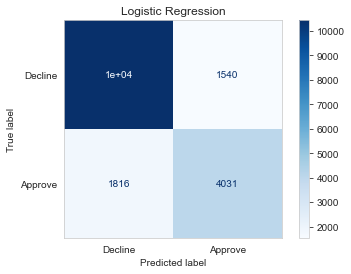

Accuracy: 0.812
Precision: 0.724
Recall: 0.689
F1: 0.706
ROC AUC: 0.8828


In [19]:
lr_optimal_model = run_model_gs(pipe_lr, params_lr, model_name = 'Logistic Regression',prefix='lr')

# k-Nearest Neighbour Classification

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Score: 0.7502285715714473
Best Parameters: {'knn__n_neighbors': 20, 'knn__weights': 'uniform'}
Score on Training Data: 0.783
Score on Testing Data: 0.752
Generalisation Score: 3.959


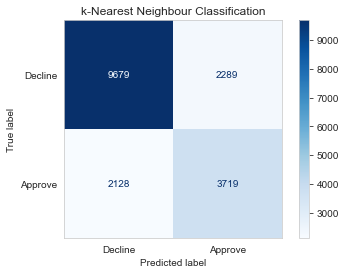

Accuracy: 0.752
Precision: 0.619
Recall: 0.636
F1: 0.627
ROC AUC: 0.8158


In [20]:
knn_optimal_model = run_model_gs(pipe_knn, params_knn, model_name = 'k-Nearest Neighbour Classification',prefix='knn')

# Random Forest 

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Score: 0.8078477715417768
Best Parameters: {'rf__max_depth': 8, 'rf__min_samples_leaf': 50, 'rf__min_samples_split': 100, 'rf__n_estimators': 80}
Score on Training Data: 0.807
Score on Testing Data: 0.803
Generalisation Score: 0.496


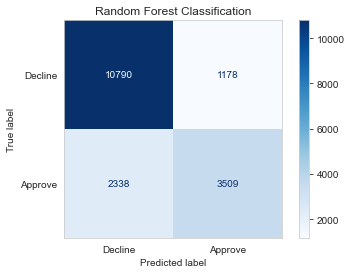

Accuracy: 0.803
Precision: 0.749
Recall: 0.6
F1: 0.666
ROC AUC: 0.8845


In [21]:
rf_optimal_model = run_model_gs(pipe_rf, params_rf, model_name = 'Random Forest Classification', prefix='rf')

# Decision Tree Classification

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Score: 0.8107588190704952
Best Parameters: {'dt__criterion': 'entropy', 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 7}
Score on Training Data: 0.82
Score on Testing Data: 0.81
Generalisation Score: 1.22


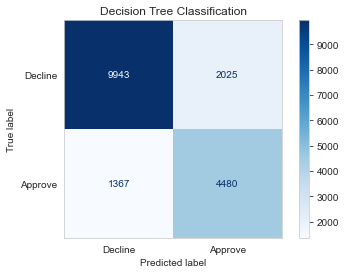

Accuracy: 0.81
Precision: 0.689
Recall: 0.766
F1: 0.725
ROC AUC: 0.8795


In [22]:
dt_optimal_model = run_model_gs(pipe_dt, params_dt, model_name = 'Decision Tree Classification', prefix='dt')

# XGBoost Classification

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Score: 0.8223788688742332
Best Parameters: {'xgb__learning_rate': 0.5, 'xgb__max_depth': 5, 'xgb__n_estimators': 10}
Score on Training Data: 0.827
Score on Testing Data: 0.824
Generalisation Score: 0.363


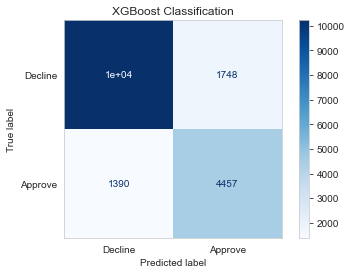

Accuracy: 0.824
Precision: 0.718
Recall: 0.762
F1: 0.739
ROC AUC: 0.8991


In [23]:
xgb_optimal_model = run_model_gs(pipe_xgb, params_xgb, model_name = 'XGBoost Classification', prefix='xgb')

# AdaBoost Classification

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score: 0.824928997654971
Best Parameters: {'ada__learning_rate': 0.5, 'ada__n_estimators': 200}
Score on Training Data: 0.828
Score on Testing Data: 0.824
Generalisation Score: 0.483


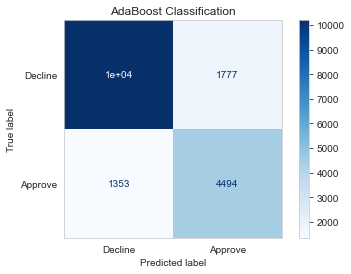

Accuracy: 0.824
Precision: 0.717
Recall: 0.769
F1: 0.742
ROC AUC: 0.9003


In [24]:
ada_optimal_model = run_model_gs(pipe_ada, params_ada, model_name = 'AdaBoost Classification',prefix='ada')

# Gradient Boosting

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Score: 0.8294519713551413
Best Parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__min_samples_leaf': 3, 'gb__min_samples_split': 3, 'gb__n_estimators': 100}
Score on Training Data: 0.845
Score on Testing Data: 0.829
Generalisation Score: 1.893


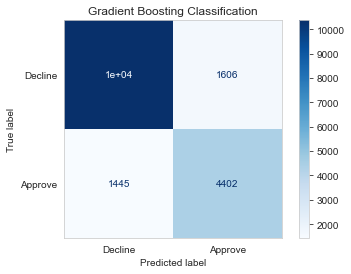

Accuracy: 0.829
Precision: 0.733
Recall: 0.753
F1: 0.743
ROC AUC: 0.9051


In [25]:
gb_optimal_model = run_model_gs(pipe_gb, params_gb, model_name = 'Gradient Boosting Classification',prefix='gb')

# Results

In [1]:
results_df = pd.DataFrame(results, index=['Train score', 'Test score', 'Generalisation','Accuracy', 'Precision', 'Recall', 'Specificity','F1', 'ROC AUC']).T
results_df                            
print(results_df.to_markdown(index=True))

NameError: name 'pd' is not defined

From the above results, we note that our Gradient Boosting Classifer performs the best in terms of accuracy. For the purpose of our problem statement, lets look at the PR curve before we decide on which model to utalize.

In [27]:
# Load the pickled model
gs_lr = pickle.load(open('./models/gs_lr.sav', 'rb'))
gs_rf = pickle.load(open('./models/gs_rf.sav', 'rb'))
gs_dt = pickle.load(open('./models/gs_dt.sav', 'rb'))
gs_knn = pickle.load(open('./models/gs_knn.sav', 'rb'))
gs_ada= pickle.load(open('./models/gs_ada.sav', 'rb'))
gs_xgb = pickle.load(open('./models/gs_xgb.sav', 'rb'))
gs_gb = pickle.load(open('./models/gs_gb.sav', 'rb'))

### Precision-Recall Curve

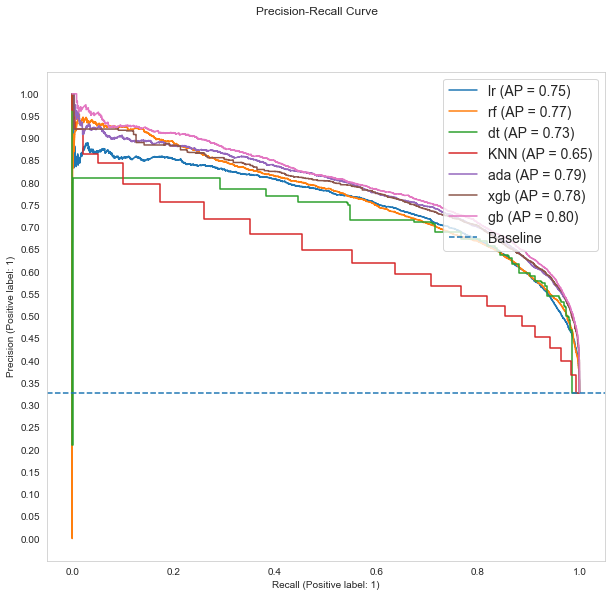

In [28]:
# Comparing Precision-Recall Curve
plt.rcParams['figure.figsize'] = (10,9)

# AP score after each model summarizes Precision-Recall curve 

# as the weighted mean of precision acheived at each threshold

fig=PrecisionRecallDisplay.from_estimator(lr_optimal_model, X_test, y_test,name="lr")
PrecisionRecallDisplay.from_estimator(rf_optimal_model, X_test, y_test, name="rf", ax= fig.ax_)
PrecisionRecallDisplay.from_estimator(dt_optimal_model, X_test, y_test, name="dt", ax= fig.ax_) 
PrecisionRecallDisplay.from_estimator(knn_optimal_model, X_test, y_test, name="KNN", ax= fig.ax_) 
PrecisionRecallDisplay.from_estimator(ada_optimal_model, X_test, y_test, name="ada", ax= fig.ax_)  
PrecisionRecallDisplay.from_estimator(xgb_optimal_model, X_test, y_test, name="xgb", ax= fig.ax_) 
PrecisionRecallDisplay.from_estimator(gb_optimal_model, X_test, y_test, name="gb", ax= fig.ax_)
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, linestyle='--', label = "Baseline")

plt.legend(loc='upper right', fontsize=14)
fig.ax_.set_yticks(np.arange(0, 1.05, 0.05))
fig.figure_.suptitle("Precision-Recall Curve")
plt.show()

In order to solve our problem statement, we looked at the highest AUC-PR curve. This curve compares precision and recall scores at different thresholds. GB model has the highest AUCPR curve score and therefore is the best performing model. 

In addition, we looked at several criterias such as :
1. Accuracy 
2. Generalisation < 5% 
3. F1 Score

Based on the above criterias, we have selected the **Gradient Boosting Classifer**.
- **Generalisation Score** of 1.893% means that the model has the ability to properly adapt to new, previously unseen data, drawn from the same distribution as the one used to create the model.

- **Accuracy Score** of 0.829. The high Accuracy score means overall, our model classifies results correct 82.9% of the time. Accuracy = (TP+TN) / Total 

- **F1 Score** of 0.736. F1 Score is an average of Precision and Recall, it means that the F1 score gives equal weight to Precision and Recall. Of all the models, Gradient Boosting Classifier has the highest F1 score indicating a good balance of both Precision and Recall. 

### AUC - ROC Curve

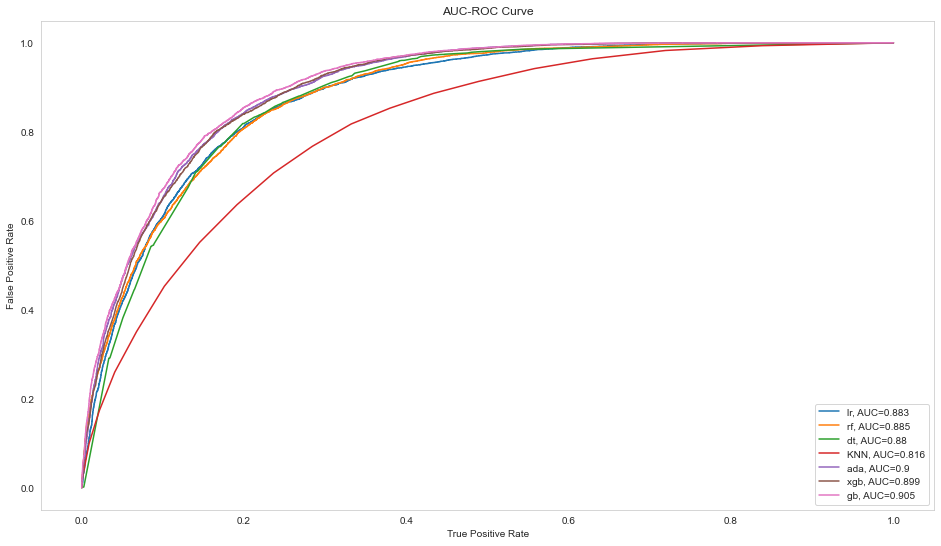

In [30]:
from sklearn import metrics

y_pred_lr = gs_lr.predict_proba(X_test)[::,1]
y_pred_rf = gs_rf.predict_proba(X_test)[::,1]
y_pred_dt = gs_dt.predict_proba(X_test)[::,1]
y_pred_knn = gs_knn.predict_proba(X_test)[::,1]
y_pred_ada = gs_ada.predict_proba(X_test)[::,1]
y_pred_xgb = gs_xgb.predict_proba(X_test)[::,1]
y_pred_gb = gs_gb.predict_proba(X_test)[::,1]


lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  y_pred_lr)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,  y_pred_rf)
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test,  y_pred_dt)
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test,  y_pred_knn)
ada_fpr, ada_tpr, _ = metrics.roc_curve(y_test,  y_pred_ada)
xgb_fpr, xgb_tpr, _ = metrics.roc_curve(y_test,  y_pred_xgb)
gb_fpr, gb_tpr, _ = metrics.roc_curve(y_test,  y_pred_gb)


#auc1 = metrics.roc_auc_score(y_test, y_pred_base)
auc2 = metrics.roc_auc_score(y_test, y_pred_lr)
auc3 = metrics.roc_auc_score(y_test, y_pred_rf)
auc4 = metrics.roc_auc_score(y_test, y_pred_dt)
#auc5 = metrics.roc_auc_score(y_test, y_pred_mnb)
auc6 = metrics.roc_auc_score(y_test, y_pred_knn)
auc7 = metrics.roc_auc_score(y_test, y_pred_ada)
auc8 = metrics.roc_auc_score(y_test, y_pred_xgb)
auc9 = metrics.roc_auc_score(y_test, y_pred_gb)


plt.figure(figsize=(16,9)).clf()
#create ROC curve
#plt.plot(base_fpr, base_tpr,label="AUC_base="+str(round(auc1,3)))
plt.plot(lr_fpr, lr_tpr,label="lr, AUC="+str(round(auc2,3)))
plt.plot(rf_fpr,rf_tpr,label="rf, AUC="+str(round(auc3,3)))
plt.plot(dt_fpr,dt_tpr,label="dt, AUC="+str(round(auc4,3)))
#plt.plot(mnb_fpr,mnb_tpr,label="AUC_mnb="+str(round(auc5,3)))
plt.plot(knn_fpr,knn_tpr,label="KNN, AUC="+str(round(auc6,3)))
plt.plot(ada_fpr,ada_tpr,label="ada, AUC="+str(round(auc7,3)))
plt.plot(xgb_fpr,xgb_tpr,label="xgb, AUC="+str(round(auc8,3)))
plt.plot(gb_fpr,gb_tpr,label="gb, AUC="+str(round(auc9,3)))

# axis labels
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')

# show title
plt.title("AUC-ROC Curve")

plt.legend(loc=4);

# plt.savefig("./images/roc_curve.png", format="png")

As shown in the chart above, the boosting classifers (Ada, XGB & GB) has the best performance when compared to the others. This is indicated by the high AUC score (~0.9) this is a good sign that our models will still able to generalise well, even when handling previously unseen data. KNN classifer performs the worst which is also reflected through its poor generalisation performance.

## Review model performance in context of Feature Importance

In the section above, we considered how well our selected model (Gradient Boost) has performed against the other models by key metrics such as ROC-AUC scores and precisions/recalls. However, we also need to think about how the model's decisions/behaviour can be explained in a clear and consistent manner - this is important in a real-world scenario from both a legal and ethical perspective, as we are assessing the prospective risk levels of numerous applicants for life insurance policies. Agreeing/rejecting applicants on insufficient/incorrect grounds could otherwise lead to reputational/financial damages.

In this section, we will now consider:
* what features have the biggest impact on the Gradien Boosting Classifier model's predictions
* how the GBClassifier model has generated its predictions based on the values of the most important features.

In [31]:
#Feature importance for our Gradient Boosting classifer
imp_gb = pd.DataFrame(gs_gb.named_steps['gb'].feature_importances_,
                      index=X_train.columns,
                      columns=['weights']).sort_values(by='weights', ascending=False)
imp_gb

,weights
BMI,0.413599
Medical_History_4,0.144665
Medical_History_23,0.134296
Product_Info_4,0.055980
Medical_Keyword_15,0.040038
Ins_Age,0.030444
Wt,0.027754
Medical_Keyword_3,0.024213
InsuredInfo_6,0.016779
Medical_History_30,0.012033


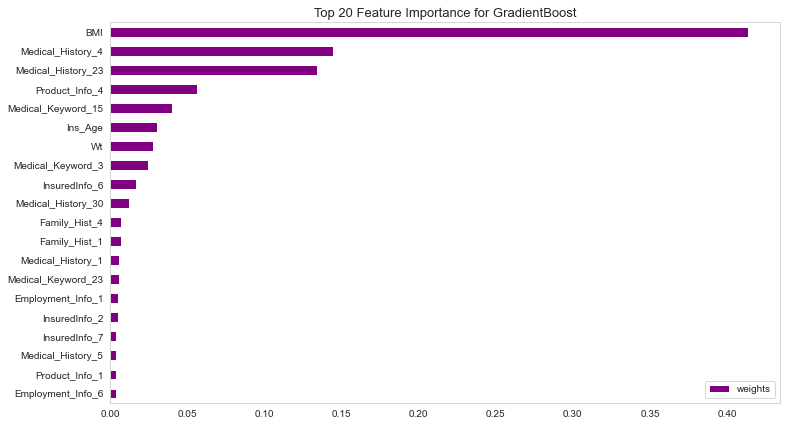

In [32]:
# Plotting Top 20 features in bar chart
imp_gb.head(20).plot(kind='barh', label=imp_gb.columns[:20], figsize=(12,7), color='purple')
plt.title('Top 20 Feature Importance for GradientBoost', fontsize=13)
plt.gca().invert_yaxis()
plt.legend(loc=4);

This plot shows that the top five most important features (in terms of Gain/model contribution) are:

* BMI
* Medical_History_4
* Medical_History_23
* Prouct_Info_4
* Wt

Interestingly, these features were also highly ranked during our EDA process which lends some credibility to the view that these features may be closely involved in governing what risk rating an applicant should be assigned.

Unfortunately, as the data has been masked, we're unable to pin-point what these features mean in the real world basis. Nonetheless, we will cover these in the recommendations portion.

# SHAP

The SHAP framework is excellent for breaking down predictions in order to show the impact of each feature. This is especially useful for when we want to explain how/why we have classified certain applicants who may have demonstrated high/low risk potential.

The advantage that this approach has over calculating permutation importances alone, is that SHAP values can express whether a feature has a broad effect across all predictions, or whether its effect is more localised for a handful of predictions and negligible in general; permutation importance simply captures the "average" impact of each feature.

Here, we will calculate the SHAP values for the test dataset to visualise how the GradientBoostingClassifier model has behaved, based on the values of the most important features.

In [33]:
# SHAP values
import shap

# fit our GB model
gs_gb.fit(X_train, y_train)

# Create object that can calculate shap values
explainer = shap.Explainer(gs_gb.predict, X_test)

# Calculate Shap values
shap_values = explainer(X_test)

Permutation explainer: 17816it [09:22, 31.19it/s]                               


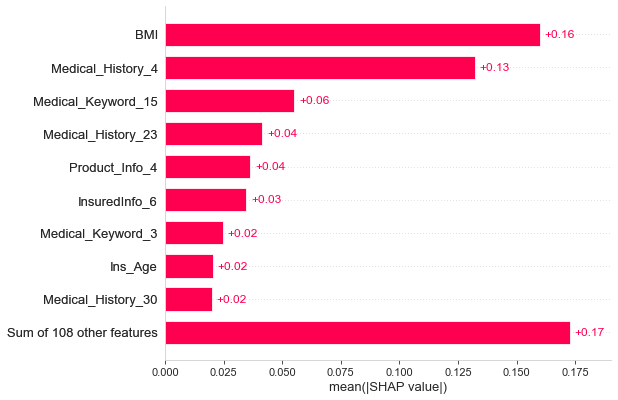

In [34]:
shap.plots.bar(shap_values, max_display=10) # default is max_display=12

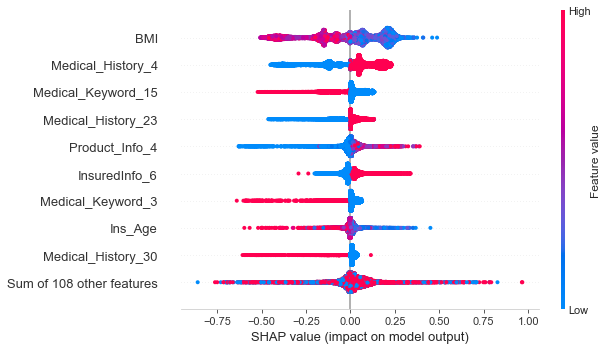

In [35]:
shap.plots.beeswarm(shap_values)

* Notably, higher values of BMI & Ins_Age have a negative impact on the prediction while lower values have a positive impact. 
* Some other well differentiated medical histories / keywords also noted.


In [36]:
shap.initjs()
shap.plots.force(shap_values[0])

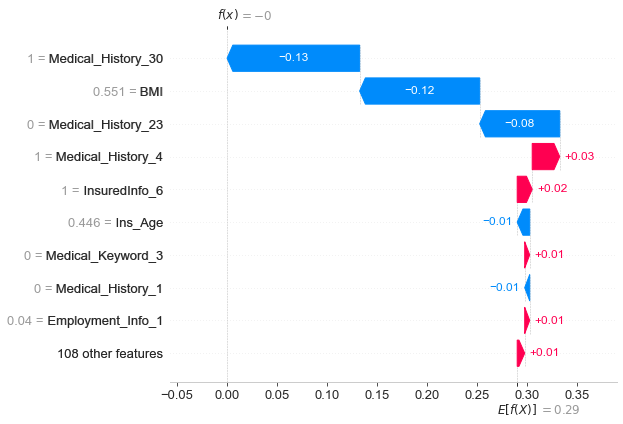

In [37]:
shap.plots.waterfall(shap_values[0])

# Conclusion

* From our results, we have selected the Gradient Boosting Classifer model. The  model has the highest Accuracy & AUC PR curve score. Indicating the best performance amongst the other models for our specific problem statement.
 
 
* As the datasets feature names have been anonymised, it has not been possible to incorporate "business logic" but rather on a best effort basis. With the help of a "deanonymised" dataset as well as the input of subject matter expertise, it may be possible to create more predictive features and validate them for use in production. 


* Albeit limited EDA can be performed due to masked data, the top features are consistent with real world application such as applicant profile (BMI , AGE , Medical Hx).


* FP & FN cases are to be considered on a risk-to-reward basis. Different stakeholders to consider. (Cost savings vs lost business and potential losses). 


# Recommendations

* Consider using  Stacking techniques to compare the result gains by stacking the top 3 models.


* In order to mitigate the risk, may wish to consider limiting model predictions to certain products or by face value (base mortality, low sum assured cover).


* Fine tuning model for precision performance by increasing threshold such that this model may be implemented in the STP process. Cost savings would be quantified by STP cases not requiring review. Rejected applications will be reviewed by existing underwriters and thus no extra implications to resources.


# Kaggle submission

In [38]:
df_test = pd.read_csv('./data/test.csv')

In [39]:
df_test.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,1,1,D3,26,0.487179,2,3,1,0.611940,0.781818,0.338912,0.472262,0.150,3,1,0.00,2,0.50,2,2,11,3,1,1,1,2,1,1,3,NaN,3,2,3,3,NaN,0.627451,0.760563,NaN,2.0,16,2,2,1,3,1,2,2,NaN,3,2,1,3,NaN,1,2,1,1,2,1,2,1,NaN,2,2,1,1,3,2,3,NaN,3,3,1,3,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,1,A2,26,0.076923,2,3,1,0.626866,0.727273,0.311715,0.484984,0.000,1,3,0.07,2,0.20,1,2,8,3,1,1,1,1,1,3,1,0.001667,1,1,2,2,NaN,0.529412,0.746479,NaN,5.0,261,3,1,1,3,2,2,1,NaN,3,2,3,3,110.0,3,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,1,D3,26,0.144667,2,3,1,0.582090,0.709091,0.320084,0.519103,0.143,9,1,0.00,2,0.45,1,2,3,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.666667,NaN,0.661972,NaN,3.0,132,2,1,1,3,2,2,2,NaN,3,2,3,3,240.0,1,3,1,1,2,1,2,3,NaN,2,2,3,1,1,2,3,NaN,1,3,1,3,2,1,3,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,1,A1,26,0.151709,2,1,1,0.522388,0.654545,0.267782,0.486962,0.210,9,1,0.00,2,1.00,2,2,3,3,1,1,1,1,1,3,1,0.000667,2,1,2,2,NaN,0.686275,0.676056,NaN,NaN,162,3,2,1,1,2,3,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,2,3,2,3,NaN,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
4,12,1,A1,26,0.076923,2,3,1,0.298507,0.672727,0.246862,0.428718,0.085,9,1,0.00,2,0.20,1,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.449275,NaN,0.380282,NaN,18.0,181,3,1,1,3,2,2,2,NaN,3,2,3,3,188.0,1,3,1,1,2,1,2,1,NaN,1,3,3,1,1,2,3,NaN,3,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
#remove columns similar to train data
cols_to_delete_due_to_missing_data = ['Id','Insurance_History_5','Family_Hist_2', 'Family_Hist_3',
                                      'Family_Hist_5','Product_Info_2','Medical_History_15', 'Medical_History_24',
                                      'Medical_History_32','Medical_History_10']

df_test = df_test.drop(columns=cols_to_delete_due_to_missing_data)

In [41]:
#median data from TRAIN dataset to fill missing values for test dataset
median_train_dict = {
    'Employment_Info_1': 0.06,
    'Employment_Info_4': 0.0,
    'Employment_Info_6': 0.25,
    'Family_Hist_4': 0.422535211,
    'Medical_History_1': 4.0
                    }

In [42]:
missing_cols_test = df_test.columns[df_test.isnull().any()]
missing_cols_test

Index(['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
       'Family_Hist_4', 'Medical_History_1'],
      dtype='object')

In [43]:
df_test['Medical_History_1'].value_counts()

1.0      2454
2.0      1856
3.0      1639
0.0      1547
4.0      1244
5.0      1172
6.0       966
7.0       734
8.0       606
12.0      579
9.0       495
10.0      410
11.0      394
13.0      270
14.0      233
16.0      189
17.0      175
15.0      170
18.0      150
19.0      132
20.0       95
24.0       90
26.0       74
29.0       72
23.0       66
21.0       66
25.0       64
22.0       62
30.0       56
28.0       49
31.0       44
27.0       44
32.0       33
36.0       28
40.0       26
55.0       23
43.0       23
35.0       23
37.0       23
33.0       19
54.0       19
38.0       17
52.0       16
41.0       16
34.0       16
53.0       15
39.0       15
44.0       15
56.0       14
42.0       13
60.0       12
48.0       12
47.0       11
45.0       10
50.0        9
63.0        8
65.0        8
49.0        7
51.0        6
58.0        6
62.0        6
76.0        6
46.0        6
67.0        5
69.0        5
57.0        5
61.0        5
77.0        4
68.0        4
64.0        4
173.0       4
72.0  

In [44]:
def fill_missing_values(df, median_dict):
    df.fillna(median_dict, inplace = True)
    return df

In [45]:
fill_missing_values(df_test, median_train_dict)

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,1,26,0.487179,2,3,1,0.611940,0.781818,0.338912,0.472262,0.150,3,1,0.00,2,0.50,2,2,11,3,1,1,1,2,1,1,3,3,2,3,3,0.760563,2.0,16,2,2,1,3,1,2,2,3,2,1,3,1,2,1,1,2,1,2,1,2,2,1,1,3,2,3,3,3,1,3,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,26,0.076923,2,3,1,0.626866,0.727273,0.311715,0.484984,0.000,1,3,0.07,2,0.20,1,2,8,3,1,1,1,1,1,3,1,1,1,2,2,0.746479,5.0,261,3,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,26,0.144667,2,3,1,0.582090,0.709091,0.320084,0.519103,0.143,9,1,0.00,2,0.45,1,2,3,3,1,1,1,2,1,1,3,3,2,3,3,0.661972,3.0,132,2,1,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,1,2,3,1,3,1,3,2,1,3,3,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,26,0.151709,2,1,1,0.522388,0.654545,0.267782,0.486962,0.210,9,1,0.00,2,1.00,2,2,3,3,1,1,1,1,1,3,1,2,1,2,2,0.676056,4.0,162,3,2,1,1,2,3,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,2,3,2,3,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
4,1,26,0.076923,2,3,1,0.298507,0.672727,0.246862,0.428718,0.085,9,1,0.00,2,0.20,1,2,8,3,1,2,1,2,1,1,3,3,2,3,2,0.380282,18.0,181,3,1,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,1,1,3,3,1,1,2,3,3,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [46]:
df_test['Medical_History_1'].value_counts()

4.0      4216
1.0      2454
2.0      1856
3.0      1639
0.0      1547
5.0      1172
6.0       966
7.0       734
8.0       606
12.0      579
9.0       495
10.0      410
11.0      394
13.0      270
14.0      233
16.0      189
17.0      175
15.0      170
18.0      150
19.0      132
20.0       95
24.0       90
26.0       74
29.0       72
23.0       66
21.0       66
25.0       64
22.0       62
30.0       56
28.0       49
31.0       44
27.0       44
32.0       33
36.0       28
40.0       26
55.0       23
43.0       23
35.0       23
37.0       23
33.0       19
54.0       19
38.0       17
52.0       16
41.0       16
34.0       16
53.0       15
39.0       15
44.0       15
56.0       14
42.0       13
60.0       12
48.0       12
47.0       11
45.0       10
50.0        9
63.0        8
65.0        8
49.0        7
51.0        6
58.0        6
62.0        6
76.0        6
46.0        6
67.0        5
69.0        5
57.0        5
61.0        5
77.0        4
68.0        4
64.0        4
173.0       4
72.0  

In [47]:
df_test.isnull().sum().sort_values(ascending=False)

Product_Info_1         0
Medical_Keyword_6      0
Medical_Keyword_18     0
Medical_Keyword_17     0
Medical_Keyword_16     0
Medical_Keyword_15     0
Medical_Keyword_14     0
Medical_Keyword_13     0
Medical_Keyword_12     0
Medical_Keyword_11     0
Medical_Keyword_10     0
Medical_Keyword_9      0
Medical_Keyword_8      0
Medical_Keyword_7      0
Medical_Keyword_5      0
Medical_History_31     0
Medical_Keyword_4      0
Medical_Keyword_3      0
Medical_Keyword_2      0
Medical_Keyword_1      0
Medical_History_41     0
Medical_History_40     0
Medical_History_39     0
Medical_History_38     0
Medical_History_37     0
Medical_History_36     0
Medical_History_35     0
Medical_History_34     0
Medical_Keyword_19     0
Medical_Keyword_20     0
Medical_Keyword_21     0
Medical_Keyword_22     0
Medical_Keyword_47     0
Medical_Keyword_46     0
Medical_Keyword_45     0
Medical_Keyword_44     0
Medical_Keyword_43     0
Medical_Keyword_42     0
Medical_Keyword_41     0
Medical_Keyword_40     0


In [48]:
df_test.shape

(19765, 117)

In [49]:
gs_gb = pickle.load(open('./models/gs_gb.sav', 'rb'))

In [50]:
Kaggle_X = df_test

In [51]:
Kaggle_X_scaled = scaler.transform(Kaggle_X)

In [52]:
y_kag_pred= gs_gb.predict_proba(Kaggle_X_scaled)
y = np.argmax(y_kag_pred, axis = 1)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [53]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [54]:
submission = pd.read_csv('data/sample_submission.csv')
submission = submission[["Id"]]

In [55]:
submission.head()

,Id
0,1
1,3
2,4
3,9
4,12


In [56]:
submission["Response"] = y

In [57]:
submission["Response"].value_counts()

0    13187
1     6578
Name: Response, dtype: int64

In [58]:
submission['Response'] = submission['Response'].replace(1,8)

In [59]:
submission['Response'] = submission['Response'].replace(0,4)

In [60]:
# Save csv for submission
submission.to_csv('./data/kaggle_submission.csv', index = False)